# CNN Interpretation - Sensitive Area Detection

Note: This notebook is desinged to run with GPU runtime.

####[CIS-01]
Import modules.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, preprocessing
from tensorflow.keras.datasets import mnist
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

####[CIS-02]
Define a function to detect the sensitive areas in the second filters against the input image, and generate a heatmap.

In [2]:
def get_heatmap(model, last_conv_layer, target_image):
    target_image = target_image.reshape(1, 28*28)
    pred_output = model.output[:, np.argmax(model.predict(target_image))]
    grads = K.gradients(pred_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    get_vals = K.function([model.inputs[0]],
                          [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_val, conv_layer_output_val = get_vals([target_image])

    heatmap = np.zeros([14, 14])
    for i in range(last_conv_layer.output.shape[-1]):
        if pooled_grads_val[i] > 0:
            heatmap += conv_layer_output_val[:, :, i] * pooled_grads_val[i]
    heatmap /= np.max(heatmap)

    heatmap2 = np.uint8(255 * cv2.resize(heatmap, (28, 28)))
    heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)
    target_image2 = np.uint8(255 * target_image.reshape(28, 28))
    target_image2 = cv2.applyColorMap(target_image2, cv2.COLORMAP_BONE)
    superimposed_img = heatmap2 + target_image2 * 0.6
    cv2.imwrite('/tmp/result.jpg', superimposed_img)

    return heatmap, preprocessing.image.load_img('/tmp/result.jpg')

####[CIS-03]
Download the MNIST dataset and store into NumPy arrays.

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(
                  (len(train_images), 784)).astype('float32') / 255
test_images = test_images.reshape(
                  (len(test_images), 784)).astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

11490434/11490434 [==============================] - 0s 0us/step


####[CIS-04]
Mount your Google Drive on `/content/gdrive`.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


####[CIS-05]
Confirm that the exported model file `MNIST_double.hd5` is on your Google Drive.

In [5]:
!ls -lh '/content/gdrive/My Drive/MNIST_double.h5'

-rw------- 1 root root 38M Feb 15 07:29 '/content/gdrive/My Drive/MNIST_double.h5'


####[CIS-06]
Restore the model from the exported model file.

In [6]:
model = models.load_model('/content/gdrive/My Drive/MNIST_double.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv_filter1 (Conv2D)       (None, 28, 28, 32)        832       
                                                                 
 max_pooling1 (MaxPooling2D  (None, 14, 14, 32)        0         
 )                                                               
                                                                 
 conv_filter2 (Conv2D)       (None, 14, 14, 64)        51264     
                                                                 
 max_pooling2 (MaxPooling2D  (None, 7, 7, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3136)              0

####[CIS-07]
Show heatmaps for sample images.

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training_v1.py:2354: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


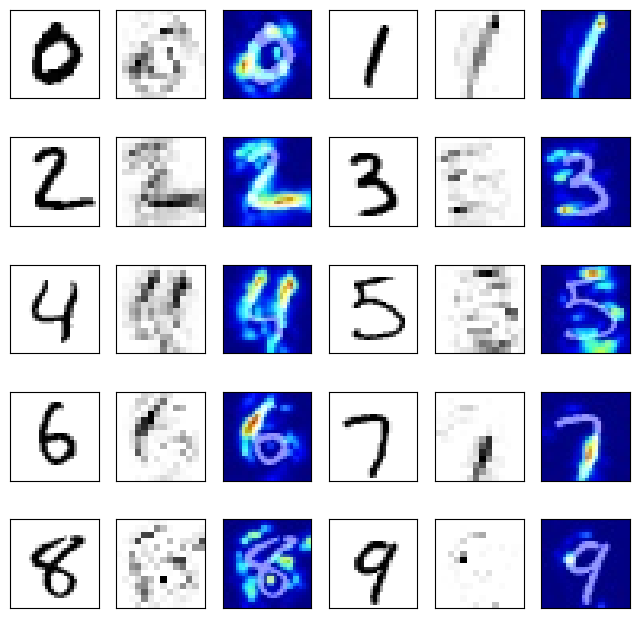

In [7]:
fig = plt.figure(figsize=(8, 8))
last_conv_layer = model.get_layer('conv_filter2')
i = 1
for img in test_images[[3, 5, 1, 32, 4, 15, 21, 254, 84, 12]]:
    heatmap, superimposed = get_heatmap(model, last_conv_layer, img)

    subplot = fig.add_subplot(5, 6, i)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(img.reshape(28, 28), vmin=0, vmax=1, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(5, 6, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(heatmap, vmin=0, vmax=1, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(5, 6, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(superimposed)

    i += 3